In [1]:
import torch
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# plotting overall correlation/error
ignored_layers = [
    "fc.",
    "fc.",
    ".in",
    "bn.out",
    "2.out",
    "5.out",
    "9.out",
    "13.out",
]
hash_to_model = {
    "fc3385ddd61e71e3234844f1584212ab": ("vgg_16_8", "svhn"),
    "0623cbc53a96baa5d56e0c04aa910cf3": ("vgg_16_16", "svhn"),
    "518ee26e9ef0aa8a2e6c0a5423cf44f2": ("vgg_16_32", "svhn"),
    "89d67a52bb2e16b7aa93e84bf7c85302": ("vgg_16_64", "svhn"),
    "69fd4b9f1c515d4ee872a935ef48b0d2": ("vgg_16_128", "svhn"),
    "ec5595f1318dc58e91af299a37eb6071": ("vgg_16_256", "svhn"),
    "688106d9fc0da7db4cebd981434750ee": ("vgg_16_8", "cifar10"),
    "812938fad9d6a452c60de777ad8b9ba2": ("vgg_16_16", "cifar10"),
    "e1ee2ce029f3688fdba8d16bcd72101b": ("vgg_16_32", "cifar10"),
    "b49ffe5e5a5c5bc82fd39df5f148ee0d": ("vgg_16_64", "cifar10"),
    "3ed390b5f8f0b92d658244d053e538e7": ("vgg_16_128", "cifar10"),
    "23d95a4841f5114daaeb195dcd3bce62": ("vgg_16_256", "cifar10"),
    "a33c07402a0c44b5ce98c8f42cc7de20": ("vgg_16_8", "cifar100"),
    "f474c902c60155e9ff25d9d4a710a869": ("vgg_16_16", "cifar100"),
    "4293247e3b0d0d76098cf66d61521885": ("vgg_16_32", "cifar100"),
    "5e2581215475976433f5c3aee127f570": ("vgg_16_64", "cifar100"),
    "5d365e1864a0effd4a92034b20b3cc5f": ("vgg_16_128", "cifar100"),
    "6020cd42026a268e84a95f95b44a931f": ("vgg_16_256", "cifar100"),
}

mask_df = []
for file in Path("../refactor-outputs/narrow-wide-stats").rglob("stats*.pt"):
    stats = torch.load(file)
    layers = [k for k in stats["layer_weight_all_size"].keys() if not any(x in k for x in ignored_layers) and k.endswith("bias")]
    for i, k in enumerate(layers):
        total = stats["layer_weight_all_size"][k]
        nonzero = stats["layer_weight_a_mask"][k]
        intersection = stats["layer_weight_ab_intersection"][k]
        union = stats["layer_weight_ab_union"][k]
        mask_df.append({
            "path": file,
            "layer": k,
            "layer.idx": i,
            "width": nonzero,
            "embed_width": total,
            "intersection": intersection,
            "intersection_fraction": intersection / total,
            "union": union,
            "union_fraction": union / total,
            "sparsity": nonzero / total,
            "expected_intersection": nonzero**2 / total,
            "expected_intersection_fraction": (nonzero / total)**2,
            "jaccard": intersection / union,
        })
mask_df = pd.DataFrame(mask_df)

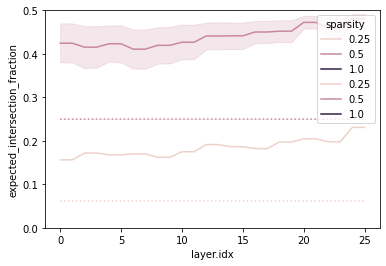

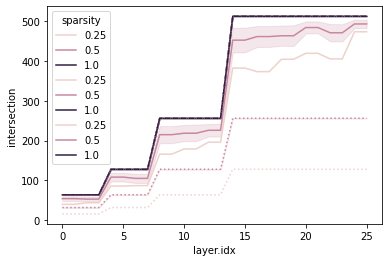

In [3]:
sns.lineplot(data=mask_df, x="layer.idx", y="expected_intersection_fraction", hue="sparsity", linestyle="dotted")
ax = sns.lineplot(data=mask_df, x="layer.idx", y="intersection_fraction", hue="sparsity")
ax.set_ylim(0., 0.5)
plt.show()
ax = sns.lineplot(data=mask_df, x="layer.idx", y="intersection", hue="sparsity")
sns.lineplot(data=mask_df, x="layer.idx", y="expected_intersection", hue="sparsity", linestyle="dotted")
sns.lineplot(data=mask_df, x="layer.idx", y="width", hue="sparsity", linestyle="dashed")
plt.show()

In [17]:
perm_to_activations = {}
perm_to_weight_layer = {}
common_keys_between_weights_activations = {}
# layers_to_perm = stats['layers_to_perm']
layers_to_perm = torch.load("../extra-stats.pt")['layers_to_perm']

for k, v in layers_to_perm.items():
    # overwrite to assign last layer with same dims
    activation_key = ".".join(k.split(".")[:-1] + ["out"])  # get rid of .weight or .bias, replace with .out
    if k.endswith(".weight"):
        perm_to_weight_layer[v] = k
        common_keys_between_weights_activations[k] = activation_key
        common_keys_between_weights_activations[activation_key] = activation_key
    perm_to_activations[v] = activation_key
print(common_keys_between_weights_activations)

{'layers.0.conv.weight': 'layers.0.conv.out', 'layers.0.conv.out': 'layers.0.conv.out', 'layers.0.bn.layernorm.weight': 'layers.0.bn.layernorm.out', 'layers.0.bn.layernorm.out': 'layers.0.bn.layernorm.out', 'layers.1.conv.weight': 'layers.1.conv.out', 'layers.1.conv.out': 'layers.1.conv.out', 'layers.1.bn.layernorm.weight': 'layers.1.bn.layernorm.out', 'layers.1.bn.layernorm.out': 'layers.1.bn.layernorm.out', 'layers.3.conv.weight': 'layers.3.conv.out', 'layers.3.conv.out': 'layers.3.conv.out', 'layers.3.bn.layernorm.weight': 'layers.3.bn.layernorm.out', 'layers.3.bn.layernorm.out': 'layers.3.bn.layernorm.out', 'layers.4.conv.weight': 'layers.4.conv.out', 'layers.4.conv.out': 'layers.4.conv.out', 'layers.4.bn.layernorm.weight': 'layers.4.bn.layernorm.out', 'layers.4.bn.layernorm.out': 'layers.4.bn.layernorm.out', 'layers.6.conv.weight': 'layers.6.conv.out', 'layers.6.conv.out': 'layers.6.conv.out', 'layers.6.bn.layernorm.weight': 'layers.6.bn.layernorm.out', 'layers.6.bn.layernorm.out'

In [32]:
weight_df = []
for file in Path("../refactor-outputs/narrow-wide-stats").rglob("stats*.pt"):
    stats = torch.load(file)
    layers = [k for k in stats["layer_weight_all_size"].keys() if not any(x in k for x in ignored_layers)]
    first_bias = [k for k in layers if "bias" in k][0]
    sparsity = stats["layer_weight_a_mask"][first_bias] / stats["layer_weight_all_size"][first_bias]
    for i, k in enumerate(layers):
        weight_df.append({
            "path": file,
            "sparsity": sparsity,
            "layer": k,
            "layer.idx": i,
            "layer.type": k.split(".")[-2] + "." + k.split(".")[-1],
            "weight_sqsum": stats["layer_weight_i_sqsum"][k],
            "norm_weight_sqsum": stats["layer_weight_i_sqsum"][k] / stats["layer_weight_i_n"][k],
        })
weight_df = pd.DataFrame(weight_df)

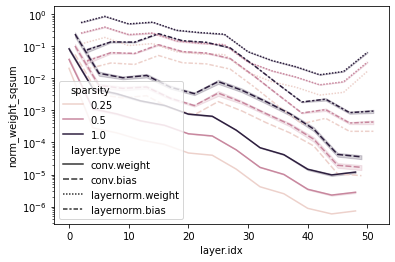

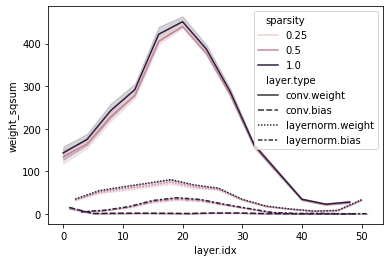

In [33]:
ax = sns.lineplot(data=weight_df, x="layer.idx", y="norm_weight_sqsum", hue="sparsity", style="layer.type")
ax.set(yscale="log")
plt.show()
ax = sns.lineplot(data=weight_df, x="layer.idx", y="weight_sqsum", hue="sparsity", style="layer.type")
plt.show()

In [43]:
mag_df = []
for file in Path("../refactor-outputs/narrow-wide-stats").rglob("stats*.pt"):
    stats = torch.load(file)
    layers = [k for k in stats["layer_weight_all_size"].keys() if not any(x in k for x in ignored_layers)]
    first_bias = [k for k in layers if "bias" in k][0]
    sparsity = stats["layer_weight_a_mask"][first_bias] / stats["layer_weight_all_size"][first_bias]
    layers = [k for k in layers if "conv.weight" in k]
    for i, k in enumerate(layers):
        act_key = common_keys_between_weights_activations[k]
        mag_df.append({
            "path": file,
            "sparsity": sparsity,
            "layer": k,
            "layer.idx": i,
            "layer.type": k.split(".")[-2] + "." + k.split(".")[-1],
            "mag_type": "weight",
            "sqsum": stats["layer_weight_i_sqsum"][k],
            "norm_sqsum": stats["layer_weight_i_sqsum"][k] / stats["layer_weight_i_n"][k],
            "error": stats["layer_weight_ab_sqsum"][k],
            "correlation": stats["layer_weight_ab_pearsonr"][k],
        })
        mag_df.append({
            "path": file,
            "sparsity": sparsity,
            "layer": k,
            "layer.idx": i,
            "layer.type": k.split(".")[-2] + "." + k.split(".")[-1],
            "mag_type": "activation",
            "sqsum": stats["layer_activation_i_sqsum"][act_key],
            "norm_sqsum": stats["layer_activation_i_sqsum"][act_key] / stats["layer_activation_i_n"][act_key],
            "error": stats["layer_activation_ab_sqsum"][act_key],
            "correlation": stats["layer_activation_ab_pearsonr"][act_key],
        })
        mag_df.append({
            "path": file,
            "sparsity": sparsity,
            "layer": k,
            "layer.idx": i,
            "layer.type": k.split(".")[-2] + "." + k.split(".")[-1],
            "mag_type": "jacobian",
            "sqsum": stats["layer_jacobian_i_sqsum"][k],
            "norm_sqsum": stats["layer_jacobian_i_sqsum"][k] / stats["layer_jacobian_i_n"][k],
            "error": stats["layer_jacobian_ab_sqsum"][k],
            "correlation": stats["layer_jacobian_ab_pearsonr"][k],
        })
mag_df = pd.DataFrame(mag_df)

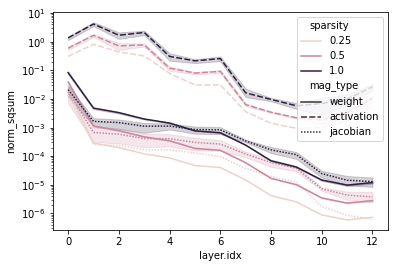

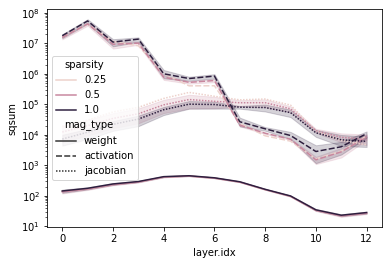

In [39]:
ax = sns.lineplot(data=mag_df, x="layer.idx", y="norm_sqsum", hue="sparsity", style="mag_type")
ax.set(yscale="log")
plt.show()
ax = sns.lineplot(data=mag_df, x="layer.idx", y="sqsum", hue="sparsity", style="mag_type")
ax.set(yscale="log")
plt.show()

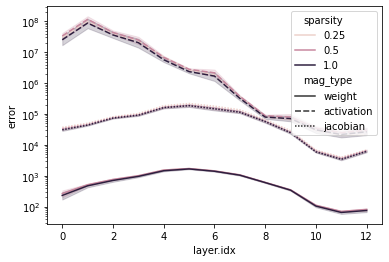

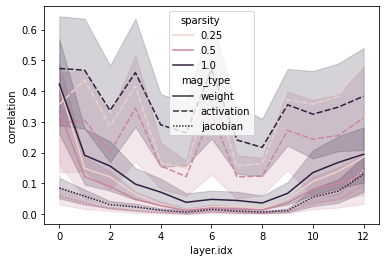

In [44]:
ax = sns.lineplot(data=mag_df, x="layer.idx", y="error", hue="sparsity", style="mag_type")
ax.set(yscale="log")
plt.show()
ax = sns.lineplot(data=mag_df, x="layer.idx", y="correlation", hue="sparsity", style="mag_type")
plt.show()